# Word Embeddings 
Here we are going to use pre-built embeddings.

### Download the GloVe word embeddings


Head to `https://nlp.stanford.edu/projects/glove/` (where you can learn more about the GloVe algorithm), and download the pre-computed 
embeddings from 2014 English Wikipedia. It's a 822MB zip file named `glove.6B.zip`, containing 100-dimensional embedding vectors for 
400,000 words (or non-word tokens). Un-zip it.

### Pre-process the embeddings


Let's parse the un-zipped file (it's a `txt` file) to build an index mapping words (as strings) to their vector representation (as number 
vectors).

In [5]:
import os
import numpy as np
glove_dir = '/Users/raz/data/glove.6B/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


## You can do it. 
If the embeddings truly represent the semanatics, then we would think semantically similar words like *doctor* and *physician* would have similar looking vectors compared to *doctor* to *chair*.  We have used `pyplot` before so we should be able to do this. Can you create two **line** plots.

1. One showing the semantics of *doctor* and *physician*
2. The other showing the semantics of *doctor* and *chair*

Does one plot look more similar than the other?

In [34]:
#TBD

## Putting it all together: from raw text to word embeddings


We will be using a model similar to the ones we used before -- embedding sentences in sequences of vectors, flattening them and training a 
`Dense` layer on top. But we will do it using pre-trained word embeddings, and instead of using the pre-tokenized IMDB data packaged in 
Keras, we will start from scratch, by downloading the original text data.

### Download the IMDB data as raw text


First, head to `http://ai.stanford.edu/~amaas/data/sentiment/` and download the raw IMDB dataset. Uncompress it.

Now let's collect the individual training reviews into a list of strings, one string per review, and let's also collect the review labels 
(positive / negative) into a `labels` list:

In [13]:
import os

imdb_dir = '/Users/raz/data/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

### Tokenize the data


Let's vectorize the texts we collected, and prepare a training and validation split.
We will merely be using the concepts we introduced earlier in this section.

Because pre-trained word embeddings are meant to be particularly useful on problems where little training data is available (otherwise, 
task-specific embeddings are likely to outperform them), we will add the following twist: we restrict the training data to its first 200 
samples. So we will be learning to classify movie reviews after looking at just 200 examples...



In [28]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words
training_samples = 200  # We will be training on 200 samples
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 87393 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


Now let's build an embedding matrix that we will be able to load into an `Embedding` layer. It must be a matrix of shape `(max_words, 
embedding_dim)`, where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in our reference word index 
(built during tokenization). Note that the index `0` is not supposed to stand for any word or token -- it's a placeholder.

In [15]:
from keras.preprocessing.text import Tokenizer
embedding_dim = 100
max_words = 10000  # We will only consider the top 10,000 words in the dataset

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

### Define a model

We will be using the same model architecture as before:
    
1. The first layer will be an embedding layer
    1. The input dimension will max_words. 
    2. The output dimension will be embedding_dim.
    3. Set `input_length=maxlen))`
2. Add a flatten layer
3. Add a dense layer with
    1. 32 units
    2. the relu activation function
4. Add a dense layer with
    1. 1 unit
    2. the sigmoid activation function
    
The model should look like

		_________________________________________________________________
		Layer (type)                 Output Shape              Param #   
		=================================================================
		embedding_4 (Embedding)      (None, 100, 100)          1000000   
		_________________________________________________________________
		flatten_3 (Flatten)          (None, 10000)             0         
		_________________________________________________________________
		dense_4 (Dense)              (None, 32)                320032    
		_________________________________________________________________
		dense_5 (Dense)              (None, 1)                 33        
		=================================================================
		Total params: 1,320,065
		Trainable params: 1,320,065
		Non-trainable params: 0
		_________________________________________________________________



In [35]:
#TBD

### Load the GloVe embeddings in the model


The `Embedding` layer has a single weight matrix: a 2D float matrix where each entry `i` is the word vector meant to be associated with 
index `i`. Simple enough. Let's just load the GloVe matrix we prepared into our `Embedding` layer, the first layer in our model:

In [30]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Additionally, we freeze the embedding layer (we set its `trainable` attribute to `False`), following the same rationale as what you are 
already familiar with in the context of pre-trained convnet features: when parts of a model are pre-trained (like our `Embedding` layer), 
and parts are randomly initialized (like our classifier), the pre-trained parts should not be updated during training to avoid forgetting 
what they already know. The large gradient update triggered by the randomly initialized layers would be very disruptive to the already 
learned features.

### Compile

Let's compile our model using

1. the `rmsprop` optimizer
2. the `binary_crossentropy` loss function
3. the `acc` metric

In [36]:
#TBD

### Train and evaluate



In [32]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 500 samples, validate on 10000 samples
Epoch 1/10
500/500 [==============================] - 1s 2ms/step - loss: 1.0766 - acc: 0.4880 - val_loss: 0.7597 - val_acc: 0.5081
Epoch 2/10
500/500 [==============================] - 1s 1ms/step - loss: 0.5645 - acc: 0.7620 - val_loss: 1.3688 - val_acc: 0.4992
Epoch 3/10
500/500 [==============================] - 1s 1ms/step - loss: 0.4505 - acc: 0.8000 - val_loss: 0.9031 - val_acc: 0.5037
Epoch 4/10
500/500 [==============================] - 1s 1ms/step - loss: 0.5126 - acc: 0.7480 - val_loss: 0.8027 - val_acc: 0.5187
Epoch 5/10
500/500 [==============================] - 1s 1ms/step - loss: 0.3026 - acc: 0.9040 - val_loss: 0.8821 - val_acc: 0.5184
Epoch 6/10
500/500 [==============================] - 1s 1ms/step - loss: 0.1833 - acc: 0.9560 - val_loss: 1.2442 - val_acc: 0.5064
Epoch 7/10
500/500 [==============================] - 1s 1ms/step - loss: 0.1808 - acc: 0.9300 - val_loss: 0.8134 - val_acc: 0.5240
Epoch 8/10
500/500 [========

### Let's plot its performance over time:

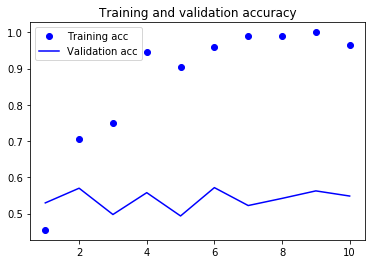

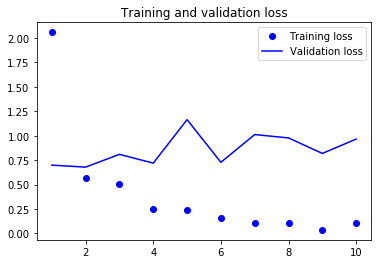

### What do those plots tell us? 

     #TBD
     
### An Experiment

Let's compare what we did above with a new model. The model is identical to the above except:

1. we won't load the pre-trained word embeddings
2. we won't freeze the embedding layer

Let's try it!


In [23]:
#TBD

In [24]:
#TBD

### Let's plot its performance over time:

### Results
Which outperforms the other: pre-trained word embeddings or jointly learned embeddings? 

### Evaluation on test data.
Finally, let's evaluate the model on the test data. First, we will need to tokenize the test data:

In [25]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

And let's load and evaluate the first model:

In [37]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

### Results
* Would you describe the accuracy as great, good, or appalling?  
* What is the accuracy?

### Can you improve the model?
You will get a bonus (to be determined)per percent improvement on the test set over 55. The best improvement will get 50xp bonus. Everyone else's will be computed from the best improvement. 